### Imports and Helper Functions

In [62]:
# Load model directly
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from watermarkers.SemStamp.sbert_lsh_model import *
from nltk import sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

def plot_embeddings_3d(embeddings, sentences, title):
    """
    Plots sentence embeddings in 3D.
    
    Parameters:
    embeddings (np.ndarray): Array containing the embeddings.
    sentences (list of str): List containing the sentences.
    title (str): Title for the plot.
    
    """
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    z = embeddings[:, 2]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points as arrows originating from the origin (0,0,0)
    for i in range(len(x)):
        ax.quiver(0, 0, 0, x[i], y[i], z[i], arrow_length_ratio=0.1)

    # Annotate the points with the original sentences
    for i, sentence in enumerate(sentences):
        ax.text(x[i], y[i], z[i], sentence)

    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")

    plt.show()

def plot_embedding_3d(embedding, sentence, title):
    """
    Plots sentence embeddings in 3D.
    
    Parameters:
    embeddings (np.ndarray): Array containing the embeddings.
    sentences (list of str): List containing the sentences.
    title (str): Title for the plot.
    """
    x = embedding[0]
    y = embedding[1]
    z = embedding[2]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')


    ax.quiver(0, 0, 0, x, y, z, arrow_length_ratio=0.1)

    ax.text(x, y, z, sentence)

    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")

    plt.show()

### CustomSentenceTransformer

In [63]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

class CustomSentenceTransformer:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v1")
        self.model = AutoModel.from_pretrained(model_name)
        
        self.model.eval()

    def encode(self, sentences, batch_size=1, convert_to_tensor=False):
        embeddings = []
        for sentence in sentences:
            inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
            with torch.no_grad():
                outputs = self.model(**inputs)

            # Mean pooling to get the sentence embedding
            embeddings = mean_pooling(outputs, inputs['attention_mask'])
            # TODO: Make sure these parameters are what you want.
            # These parameters are from the HF page for "sentence-transformers/all-mpnet-base-v1". -- Boran
            embeddings = F.normalize(embeddings, p=2, dim=1)

        return embeddings if not convert_to_tensor else torch.stack(embeddings)
    
# Instantiate the custom transformer
lsh_dim = 3
lmbd = 0.25

model_name = "AbeHou/SemStamp-c4-sbert"
custom_embedder = CustomSentenceTransformer(model_name)

In [64]:
embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v1")

### Sanity Checks

torch.Size([1, 8, 768])


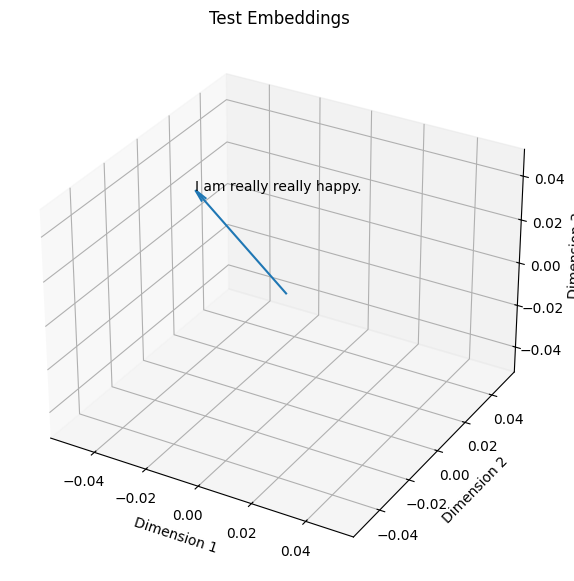

In [65]:
test_sentence = "I am happy."
test_sents = sent_tokenize(test_sentence)
test_embeddings = np.stack(custom_embedder.encode(test_sents, batch_size=1))
plot_embeddings_3d(test_embeddings, test_sents, "Test Embeddings")

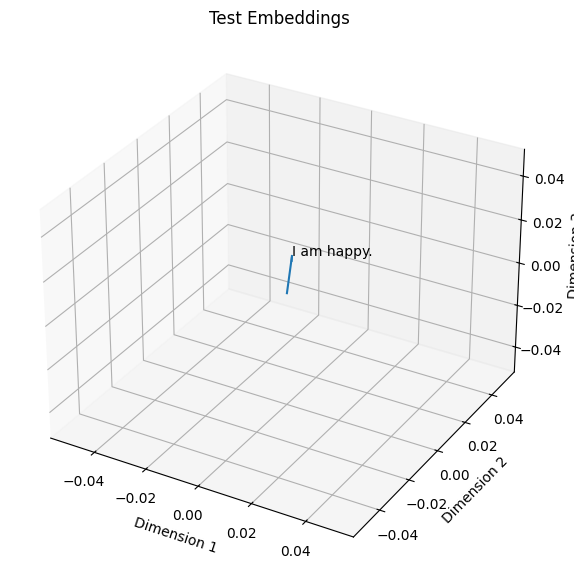

In [66]:
test_sentence = "I am happy."
test_sents = sent_tokenize(test_sentence)
test_embeddings = np.stack(embedder.encode(test_sents, batch_size=1))
plot_embeddings_3d(test_embeddings, test_sents, "Test Embeddings")

In [67]:
custom_embedder.embedder.

SyntaxError: invalid syntax (3299142987.py, line 1)